# **SLDS Duffing**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time as time
import random 
import reservoirpy.datasets as rsvp_d

from scipy.special import logsumexp
from scipy.stats import multivariate_normal, invwishart, matrix_normal

## Data generation

In [2]:
t1 = time.time() #times the computation

# parameters (mass = 1)
a = 0.5
b = 1/16.0
F_0 = 2.5
omega = 2.0
gamma = 0.1
h = 1e-1 # time step was 1e-1
period = 2*np.pi/(1.0*omega)
# length of the simulation
T = 500
t = np.arange(0,10*T*h,h)

def x_2(x,v):
    '''
    second derivative term for Taylor series
    '''
    return -gamma*v + 2.0*a*x - 4.0*b*x*x*x

def x_3(x2,x,v):
    '''
    third derivative term for Taylor series
    '''
    return -gamma*x2 + 2.0*a*v -12.0*b*x*x*v

def x_4(x3,x2,x,v):
    '''
    fourth derivative term for Taylor series
    '''
    return -gamma*x3 + 2.0*a*x2 -12.0*b*x*x*x2 - 24.0*b*v*v*x

def x_5(x4,x3,x2,x,v):
    '''
    fifth derivative term for Taylor series
    '''
    return -gamma*x4 + 2*a*x3 -12.0*b*(x*x*x3 + 2.0*x2*x*v) -24.0*b*(v*v*v+2*x*v*x2)

# Trigonometric terms in derivatives. Evaluate before the loop
x2F = F_0*np.cos(omega*t)
x3F = -F_0*omega*np.sin(omega*t)
x4F = -F_0*omega*omega*np.cos(omega*t)
x5F = F_0*omega*omega*omega*np.sin(omega*t)

# coefficients in front of Taylor series expansion
# Evaluate before the loop
coef1 = 0.5*h**2.0
coef2 = 1.0/6.0*h**3.0
coef3 = 1.0/24.0*h**4.0
coef4 = 1.0/120.0*h**5.0

# initial conditions
v = 0.0
x = 0.5

xs = np.zeros(len(t))
velocity = np.zeros(len(t))
xs[0] = x

for i in range(1,len(t)):
    d2 = x_2(x,v) + x2F[i]
    d3 = x_3(d2,x,v) + x3F[i]
    d4 = x_4(d3,d2,x,v) + x4F[i]
    d5 = x_5(d4,d3,d2,x,v) + x5F[i]
    # Taylor series expansion for x,v. Order h^5
    x += v*h + coef1*d2 + coef2*d3 + coef3*d4 + coef4*d5
    v += d2*h + coef1*d3 + coef2*d4 + coef3*d5
    xs[i] = x
    velocity[i] = v

##f = open('data_duffing_pos_vel.txt','w')
##for i in range(len(t)):
##    f.write('%f %f' %(xs[i], velocity[i]))
##f.close()

# obtain phase space points at integer multiples of the period for Poincare plot
strange_attractor = np.zeros([int(T/period),2])
k = 1
for i in range(len(t)):
    if abs(t[i]-k*period)<h:
        strange_attractor[k-1,0] = xs[i]
        strange_attractor[k-1,1] = velocity[i]
        k+=1

t2 = time.time()
print ('computation takes ',t2-t1,' seconds.')

computation takes  0.024674654006958008  seconds.


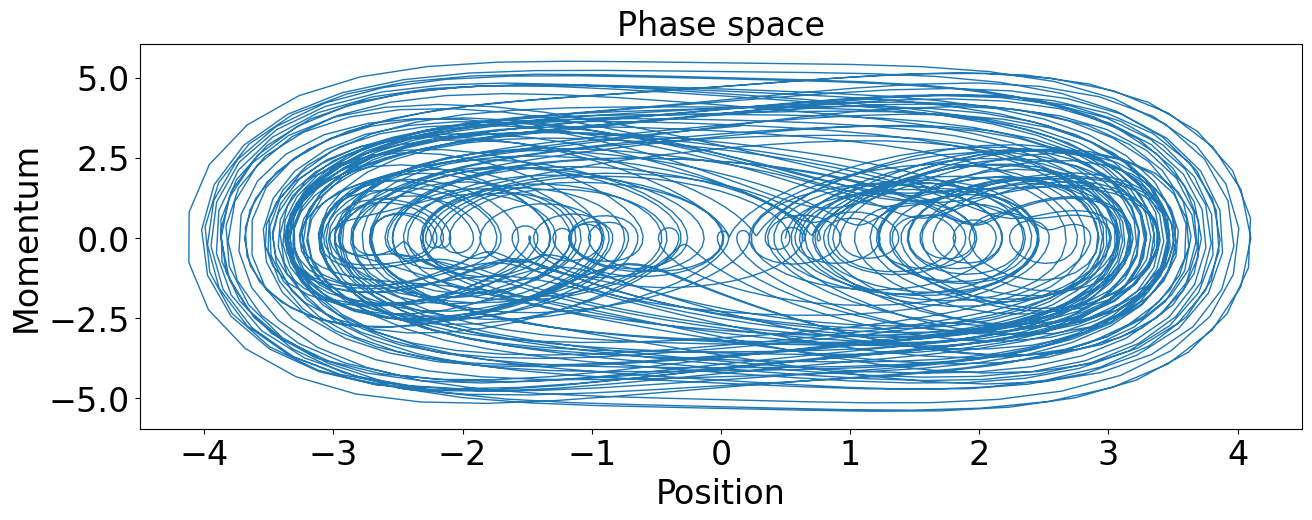

In [3]:
# Phase space
plt.figure(figsize=(15,5))

plt.figure(1)
plt.plot(xs[-int(30000):],velocity[-30000:],linewidth=1.0)
plt.title('Phase space',{'fontsize':24})
plt.xlim([-4.5,4.5])
plt.xlabel('Position',{'fontsize':24})
plt.ylabel('Momentum',{'fontsize':24})
plt.tick_params(axis='both',labelsize=24)

plt.show()

In [4]:
y = np.stack([xs, velocity], axis=0).T[:2500, :]/5
y.shape

(2500, 2)

(-1.0, 1.0)

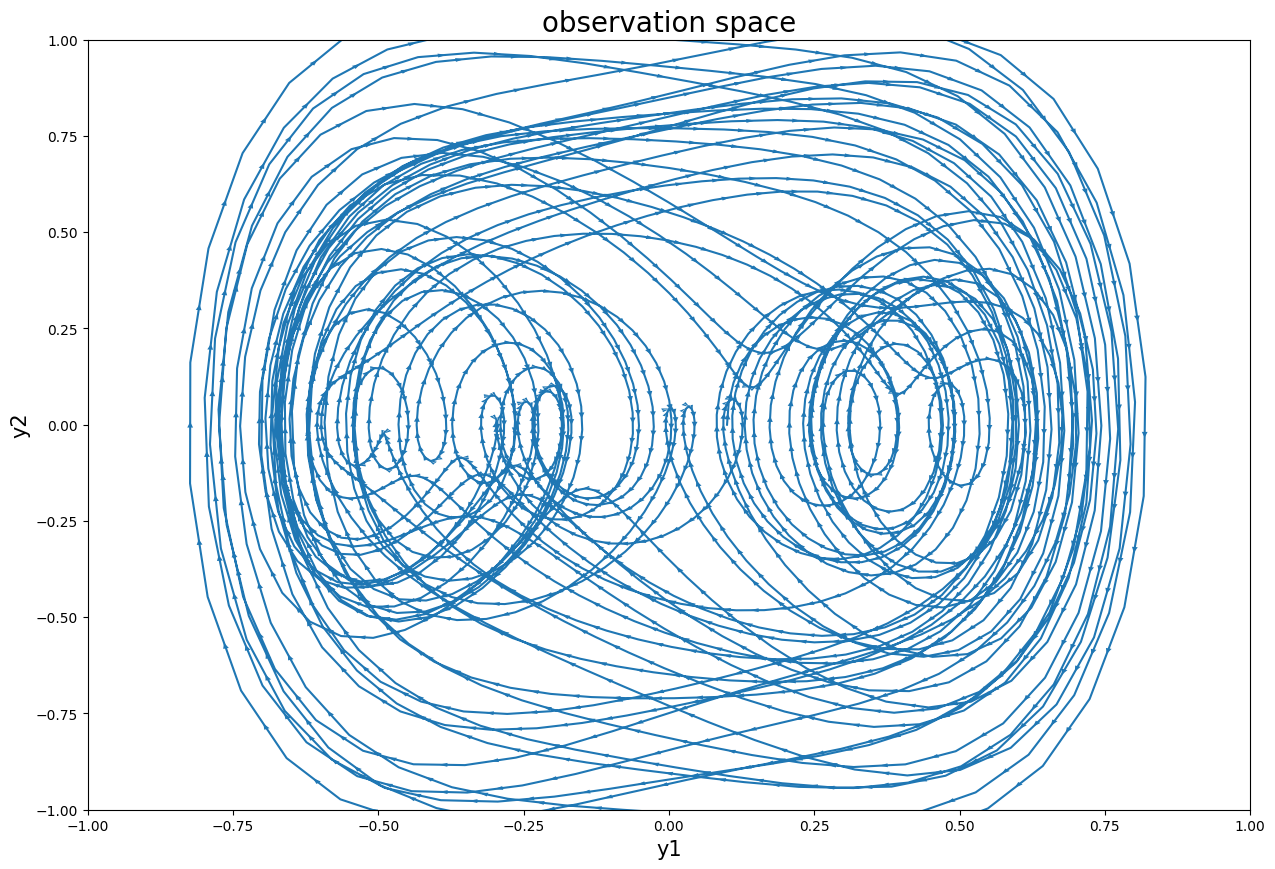

In [5]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1])

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [20]:
def plot_latent_state_dynamic(X1, X2, A, b, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 6*K))
    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        if show_fixed_point:
            ax[k].scatter(x_star[k][0], x_star[k][1])

        if show_states:
            c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else "y" if i == 5 else "k" if i == 6 else "0" if i == 7 else "0.8" if i == 8 else "1" if i == 9 else i for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, 0], y[t:t+2, 1], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
            '''
            # code to add the arrows in the middle of the lines (fix head_width if needed)
            for t in range(y.shape[0]-1):
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = 'navy')
            '''
            

In [7]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [8]:
T = y.shape[0] # number of time steps
N = 2 # observation dim
K = 9 # latent dim

L = 100 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

#S = generate_random_semipositive_matrix(N, 1)
S = 0.0001*np.eye(N, N)
nu = N
C = 0.1*np.random.randn(N, N+1)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 0.1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0] = 1*np.random.randn(K, N, N+1)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([0.0001*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[-1.07897592  0.27808562  0.28728563]
  [-0.42162562  0.16088698 -0.10306868]]

 [[-0.03569209 -0.30658768  0.87766547]
  [-0.16957635 -1.07824404  0.0444424 ]]

 [[ 0.00369165  0.65861956 -0.30970778]
  [-0.66673267  2.6081169   0.8089435 ]]

 [[-0.02539553  0.85734019 -0.3838773 ]
  [ 1.46007168 -1.09694081 -0.93829468]]

 [[ 0.52230182  0.53870378  1.01805109]
  [ 0.97915895 -1.46279181 -1.14334984]]

 [[ 0.82418059 -0.69067428 -0.85773958]
  [-1.01022864 -0.32739959 -1.26874221]]

 [[-0.27404875  1.58297734 -0.33506281]
  [ 0.46251047  1.08517653 -0.05345822]]

 [[ 0.82314714 -0.83573592 -1.07596875]
  [ 0.27147437  0.4209082  -1.60745191]]

 [[ 0.8847519   0.63139675 -0.30882153]
  [ 1.59311382  0.37721328 -0.70155644]]]


In [9]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

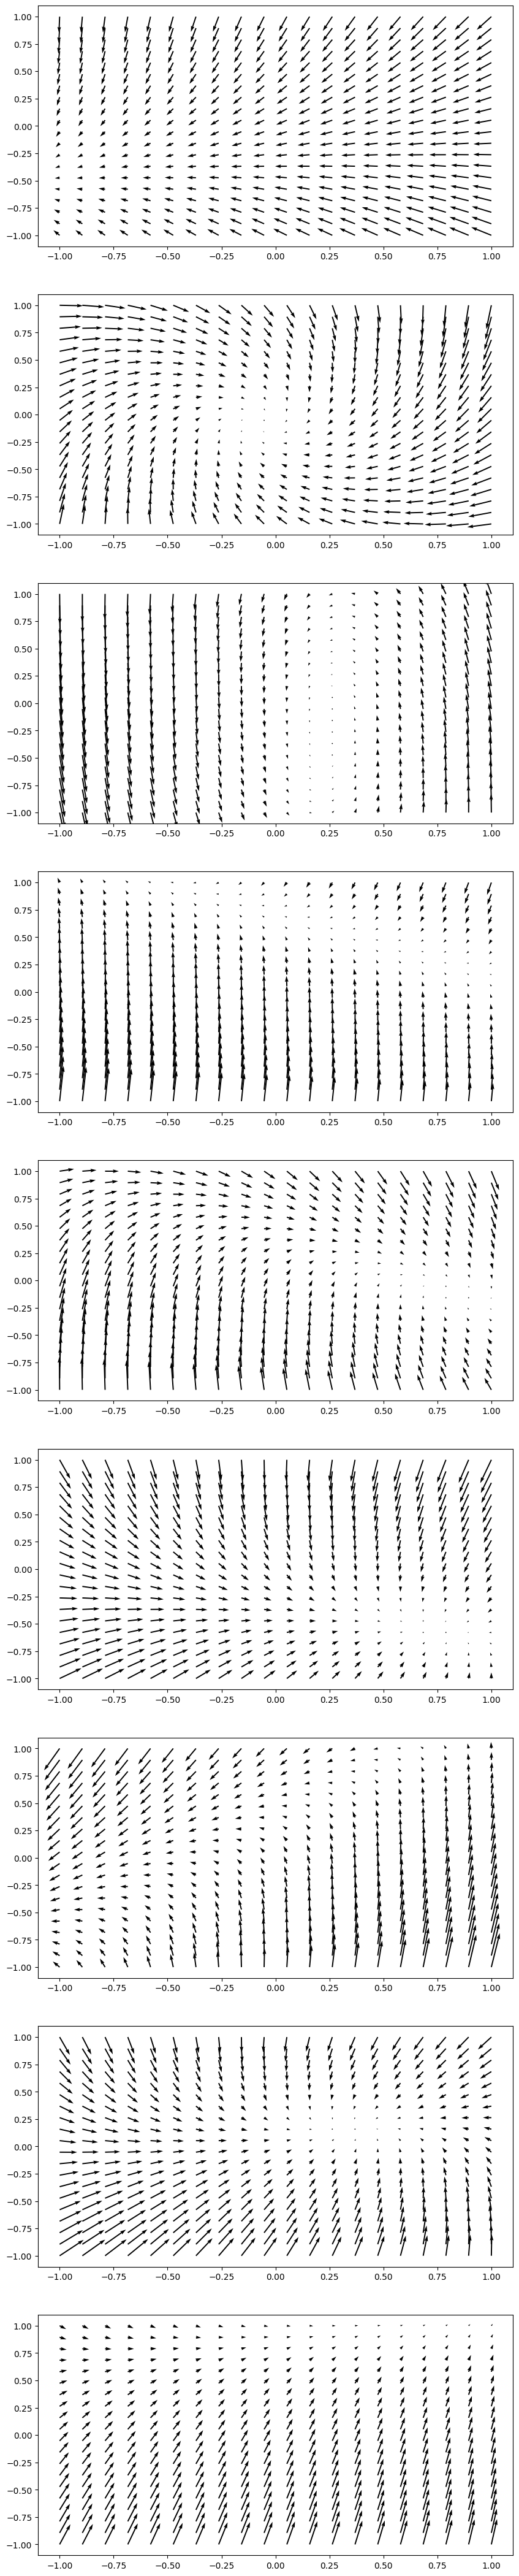

In [10]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf, b_inf, show_fixed_point = False)

In [11]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [12]:
### my version of sampling z_t

def myconditionals(M_inf_l, A_hat_inf_l, Q_inf_l, z_inf_prec):

    # discrete conditional distribution P(z_t|...) at each time 1,...,T
    p_z = np.zeros((T, K))
    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # P(z_1|...)
    for k in range(K):
        log_p_z[0, k] = np.log(M_inf_l[z_inf_prec[1], k])
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # P(z_t|...) for t in 2:T-1
    for t in range(1, T-1):
        for k in range(K):
            y_hat = np.concatenate([np.array([1]), y[t-1]])
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = rv.logpdf(x) + np.log(M_inf_l[z_inf_prec[t+1], k] * M_inf_l[k, z_inf_l[t-1]])
            #print(rv.pdf(x))

        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    # P(z_T|...)        
    for k in range(K):
        y_hat = np.concatenate([np.array([1]), y[T-2]])
        rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
        x = y[T-1] - np.dot(A_hat_inf_l[k], y_hat)
        log_p_z[T-1, k] = rv.logpdf(x) + np.log(M_inf_l[k, z_inf_l[T-2]])
    log_p_z[T-1] = log_p_z[T-1] - logsumexp(log_p_z[T-1])
    z_inf_l[T-1] = np.random.choice(K, p = np.exp(log_p_z[T-1]))

    return z_inf_l


In [13]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)


 SAMPLE: 0

 SAMPLE: 1

 SAMPLE: 2

 SAMPLE: 3

 SAMPLE: 4

 SAMPLE: 5

 SAMPLE: 6

 SAMPLE: 7

 SAMPLE: 8

 SAMPLE: 9

 SAMPLE: 10

 SAMPLE: 11

 SAMPLE: 12

 SAMPLE: 13

 SAMPLE: 14

 SAMPLE: 15

 SAMPLE: 16

 SAMPLE: 17

 SAMPLE: 18

 SAMPLE: 19

 SAMPLE: 20

 SAMPLE: 21

 SAMPLE: 22

 SAMPLE: 23

 SAMPLE: 24

 SAMPLE: 25

 SAMPLE: 26

 SAMPLE: 27

 SAMPLE: 28

 SAMPLE: 29

 SAMPLE: 30

 SAMPLE: 31

 SAMPLE: 32

 SAMPLE: 33

 SAMPLE: 34

 SAMPLE: 35

 SAMPLE: 36

 SAMPLE: 37

 SAMPLE: 38

 SAMPLE: 39

 SAMPLE: 40

 SAMPLE: 41

 SAMPLE: 42

 SAMPLE: 43

 SAMPLE: 44

 SAMPLE: 45

 SAMPLE: 46

 SAMPLE: 47

 SAMPLE: 48

 SAMPLE: 49

 SAMPLE: 50

 SAMPLE: 51

 SAMPLE: 52

 SAMPLE: 53

 SAMPLE: 54

 SAMPLE: 55

 SAMPLE: 56

 SAMPLE: 57

 SAMPLE: 58

 SAMPLE: 59

 SAMPLE: 60

 SAMPLE: 61

 SAMPLE: 62

 SAMPLE: 63

 SAMPLE: 64

 SAMPLE: 65

 SAMPLE: 66

 SAMPLE: 67

 SAMPLE: 68

 SAMPLE: 69

 SAMPLE: 70

 SAMPLE: 71

 SAMPLE: 72

 SAMPLE: 73

 SAMPLE: 74

 SAMPLE: 75

 SAMPLE: 76

 SAMPLE:

In [14]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[50:], return_counts=True)
print(dict(zip(unique, counts)))

[5 5 5 ... 1 2 4]
[4 1 1 ... 3 4 4]
[0 2 2 ... 6 6 6]
[3.18 2.02 2.02 ... 5.86 5.82 5.78]
{0: 6, 1: 41903, 2: 57415, 3: 3611, 4: 8, 5: 1, 6: 22051, 7: 2, 8: 3}


In [15]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.09258053 0.10712181 0.13041717 0.1195549  0.1020187  0.10739556
  0.10800721 0.11703011 0.11587399]
 [0.00143156 0.87597261 0.0685418  0.00201999 0.00640586 0.0013501
  0.03936139 0.00288081 0.00203588]
 [0.00142156 0.0658762  0.89484899 0.00445806 0.00105634 0.00115845
  0.02728236 0.00265727 0.00124076]
 [0.01478967 0.0147096  0.02054666 0.68638721 0.0157066  0.01500688
  0.20125718 0.01480629 0.01678991]
 [0.1215898  0.11723558 0.11267304 0.10698915 0.12372675 0.11066706
  0.10179948 0.10204031 0.10327881]
 [0.10493012 0.12209149 0.11997334 0.09502887 0.11108316 0.12168526
  0.10190798 0.12383936 0.09946042]
 [0.00293034 0.04202962 0.09132294 0.03359239 0.00206706 0.00232933
  0.81717369 0.00495787 0.00359678]
 [0.12571778 0.1015915  0.11054038 0.0996377  0.10078585 0.10441852
  0.11161337 0.1212542  0.12444069]
 [0.1062915  0.09533067 0.12578331 0.10397545 0.09378867 0.12279233
  0.09759547 0.12831977 0.12612282]]
[0.00569004 0.31927009 0.41817167 0.03907651 0.00684002 0.005494

In [16]:
print(np.mean(A_hat_inf, axis = 0))

[[[-6.13026975e-02 -5.28074738e-02  6.72015599e-02]
  [ 1.60216427e-02 -2.50453980e-02  1.42986644e-01]]

 [[-2.22684601e-03  9.84377454e-01  1.07451179e-01]
  [-3.76767728e-02 -4.18313450e-02  9.78747992e-01]]

 [[ 1.52185222e-03  9.94472094e-01  9.54486335e-02]
  [ 2.30603450e-02  2.91007096e-03  9.84638103e-01]]

 [[-7.32370896e-04  9.79955535e-01  9.03097081e-02]
  [ 1.75461530e-02 -3.20554267e-01  9.24363845e-01]]

 [[-4.17645537e-02 -4.28096161e-02  7.33020941e-02]
  [ 2.88734518e-02 -5.66728192e-02  1.40162565e-01]]

 [[ 3.19302438e-03 -5.49209741e-02  5.42516900e-02]
  [ 4.10573800e-02 -5.88657119e-02  1.57576903e-01]]

 [[-2.94468936e-03  9.95601764e-01  9.39074815e-02]
  [ 1.08124431e-03 -1.84309132e-01  9.47903478e-01]]

 [[-3.28822540e-02 -6.31796255e-02  5.18487602e-02]
  [ 2.65199788e-02 -2.91470291e-02  1.30850134e-01]]

 [[-3.94563102e-02 -4.98638903e-02  6.12759874e-02]
  [ 3.55696622e-02 -2.35622998e-02  1.41878738e-01]]]


In [17]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[ 0.00754767 -0.00317768]
 [-0.00317768  0.00645461]]
[0.01022547 0.00377681]
[[1.32495976e-04 2.15159690e-05]
 [2.15159690e-05 4.82581620e-04]]
[0.00013118 0.0004839 ]
[[1.04502650e-04 2.63394118e-05]
 [2.63394118e-05 5.25599054e-04]]
[0.00010286 0.00052724]
[[ 0.00184806 -0.0004553 ]
 [-0.0004553   0.0018697 ]]
[0.00140345 0.0023143 ]
[[0.01221902 0.01023172]
 [0.01023172 0.0127661 ]]
[0.00225718 0.02272793]
[[0.42576456 0.25014055]
 [0.25014055 0.17969631]]
[0.58149143 0.02396945]
[[ 2.48146725e-04 -3.45677123e-06]
 [-3.45677123e-06  7.94663448e-04]]
[0.00024812 0.00079469]
[[0.00843883 0.00609075]
 [0.00609075 0.0182944 ]]
[0.00553206 0.02120117]
[[0.0083527  0.00993951]
 [0.00993951 0.01978241]]
[0.00260224 0.02553287]


In [18]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

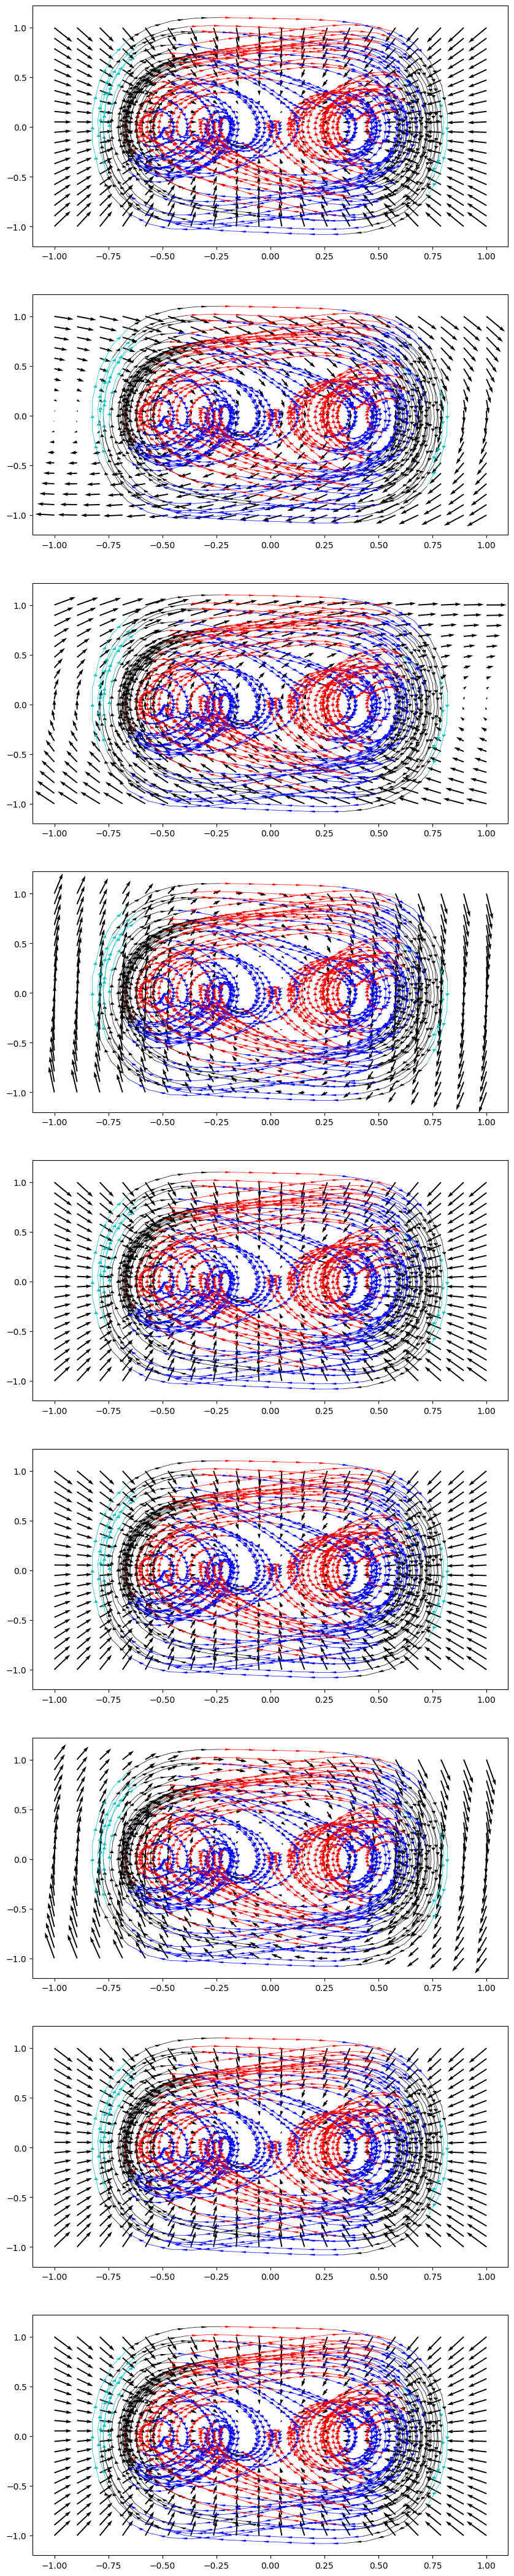

In [21]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, show_fixed_point = False, show_states = True, z = z_inf[10])